# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

from mlde_analysis.utils import chained_groupby_map
from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map
from mlde_analysis.bootstrap import resample_examples
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp, plot_ccs_fc_figure, ccs_fc_da
from mlde_analysis.distribution import PER_GRIDBOX_QUANTILES, normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias, compute_metrics, DIST_THRESHOLDS
from mlde_analysis.fractional_contribution import compute_fractional_contribution, frac_contrib_change, fc_bins
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS
from mlde_analysis.display import VAR_RANGES, pretty_table
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() } | {"CPM": {"source": "CPM", "color": "black"}}

In [ ]:
CCS_SEASONS = ["DJF", "JJA"]

In [ ]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())])

## Figure: Climate change signal

* Per time period freq density histogram
* Mean change diff: $(\mu_{{ML}}^{{future}} - \mu_{{ML}}^{{hist}})/\mu_{{ML}}^{{hist}} - (\mu_{{CPM}}^{{future}} - \mu_{{CPM}}^{{hist}})/\mu_{{CPM}}^{{hist}}$

#### pr

##### CPMGEM_GCM

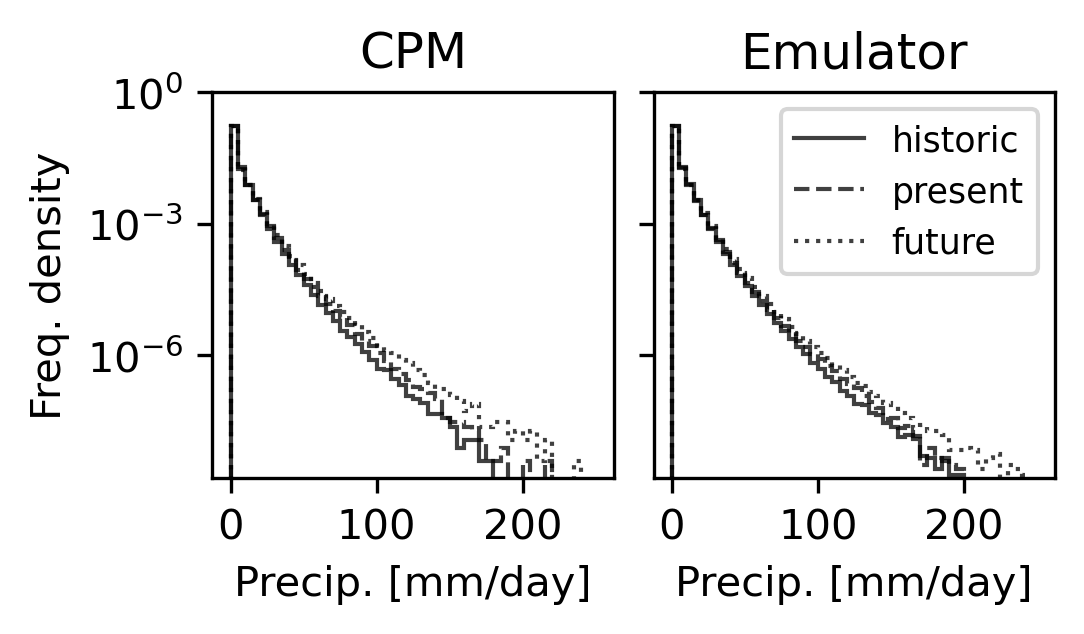

##### CPMGEM_cCPM

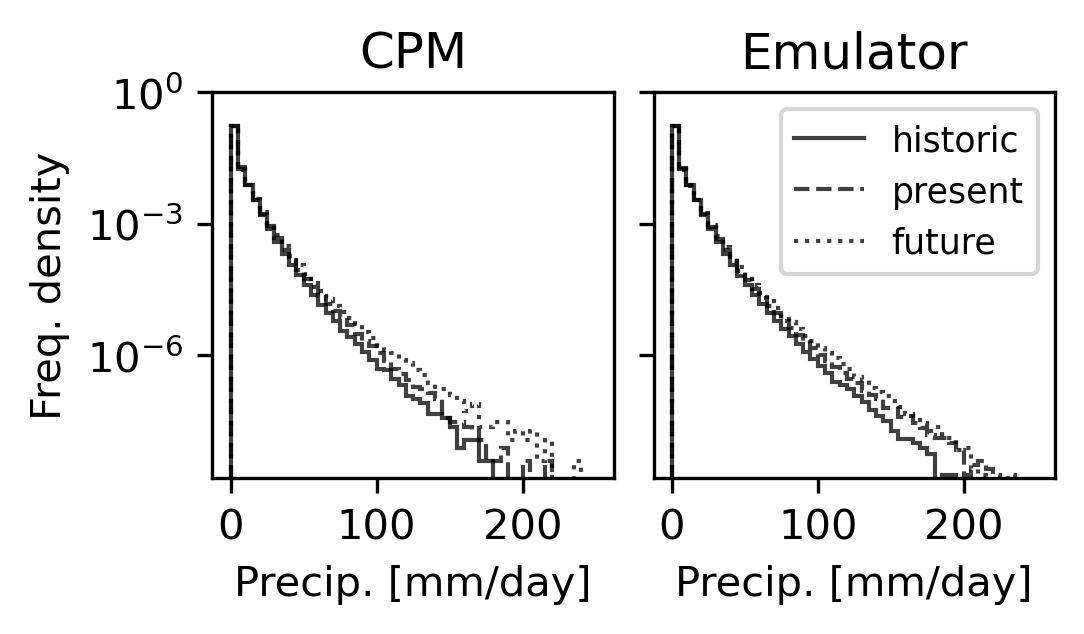

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"#### {var}", raw=True)
    for model, model_ds in CCS_DS.groupby("model"):
        IPython.display.display_markdown(f"##### {model}", raw=True)

        pred_da = model_ds[f"pred_{var}"]
        cpm_da = model_ds[f"target_{var}"]
        
        fig, axd = plt.subplot_mosaic([["cpm", "model"]], figsize=(3.5, 2), constrained_layout=True, sharex=True, sharey=True)
        
        hrange=VAR_RANGES[var]
        plot_hist_per_tp(cpm_da, axd["cpm"], title="CPM",  hrange=hrange, legend=False)
        plot_hist_per_tp(pred_da, axd["model"], title="Emulator", hrange=hrange)
        axd["model"].set_ylabel(None)

        plt.show()

#### pr

##### CPMGEM_GCM

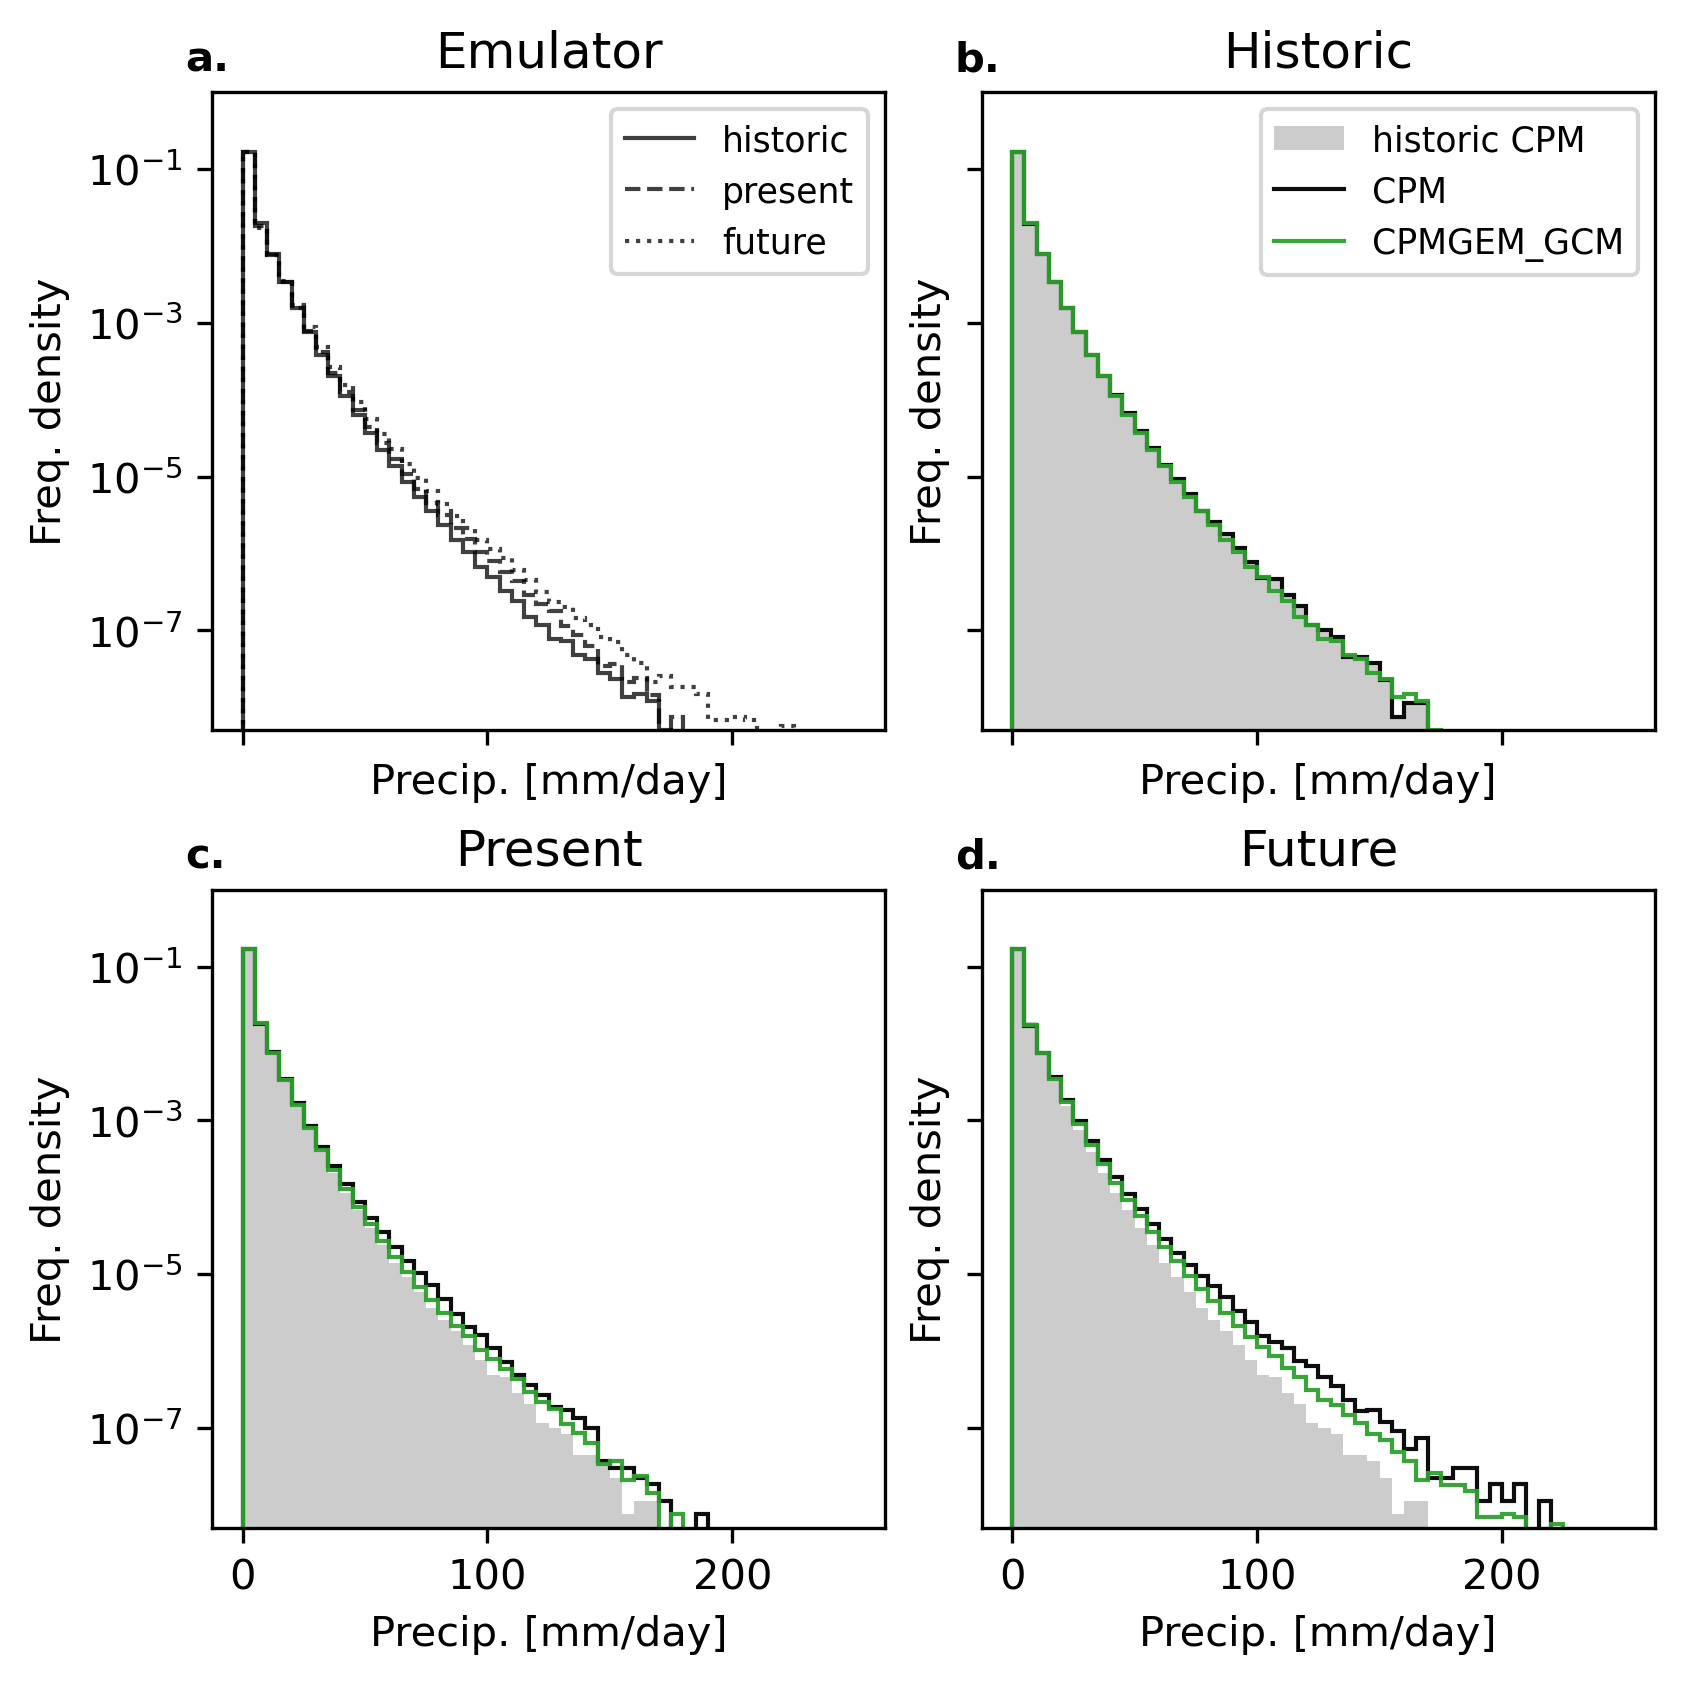

##### CPMGEM_cCPM

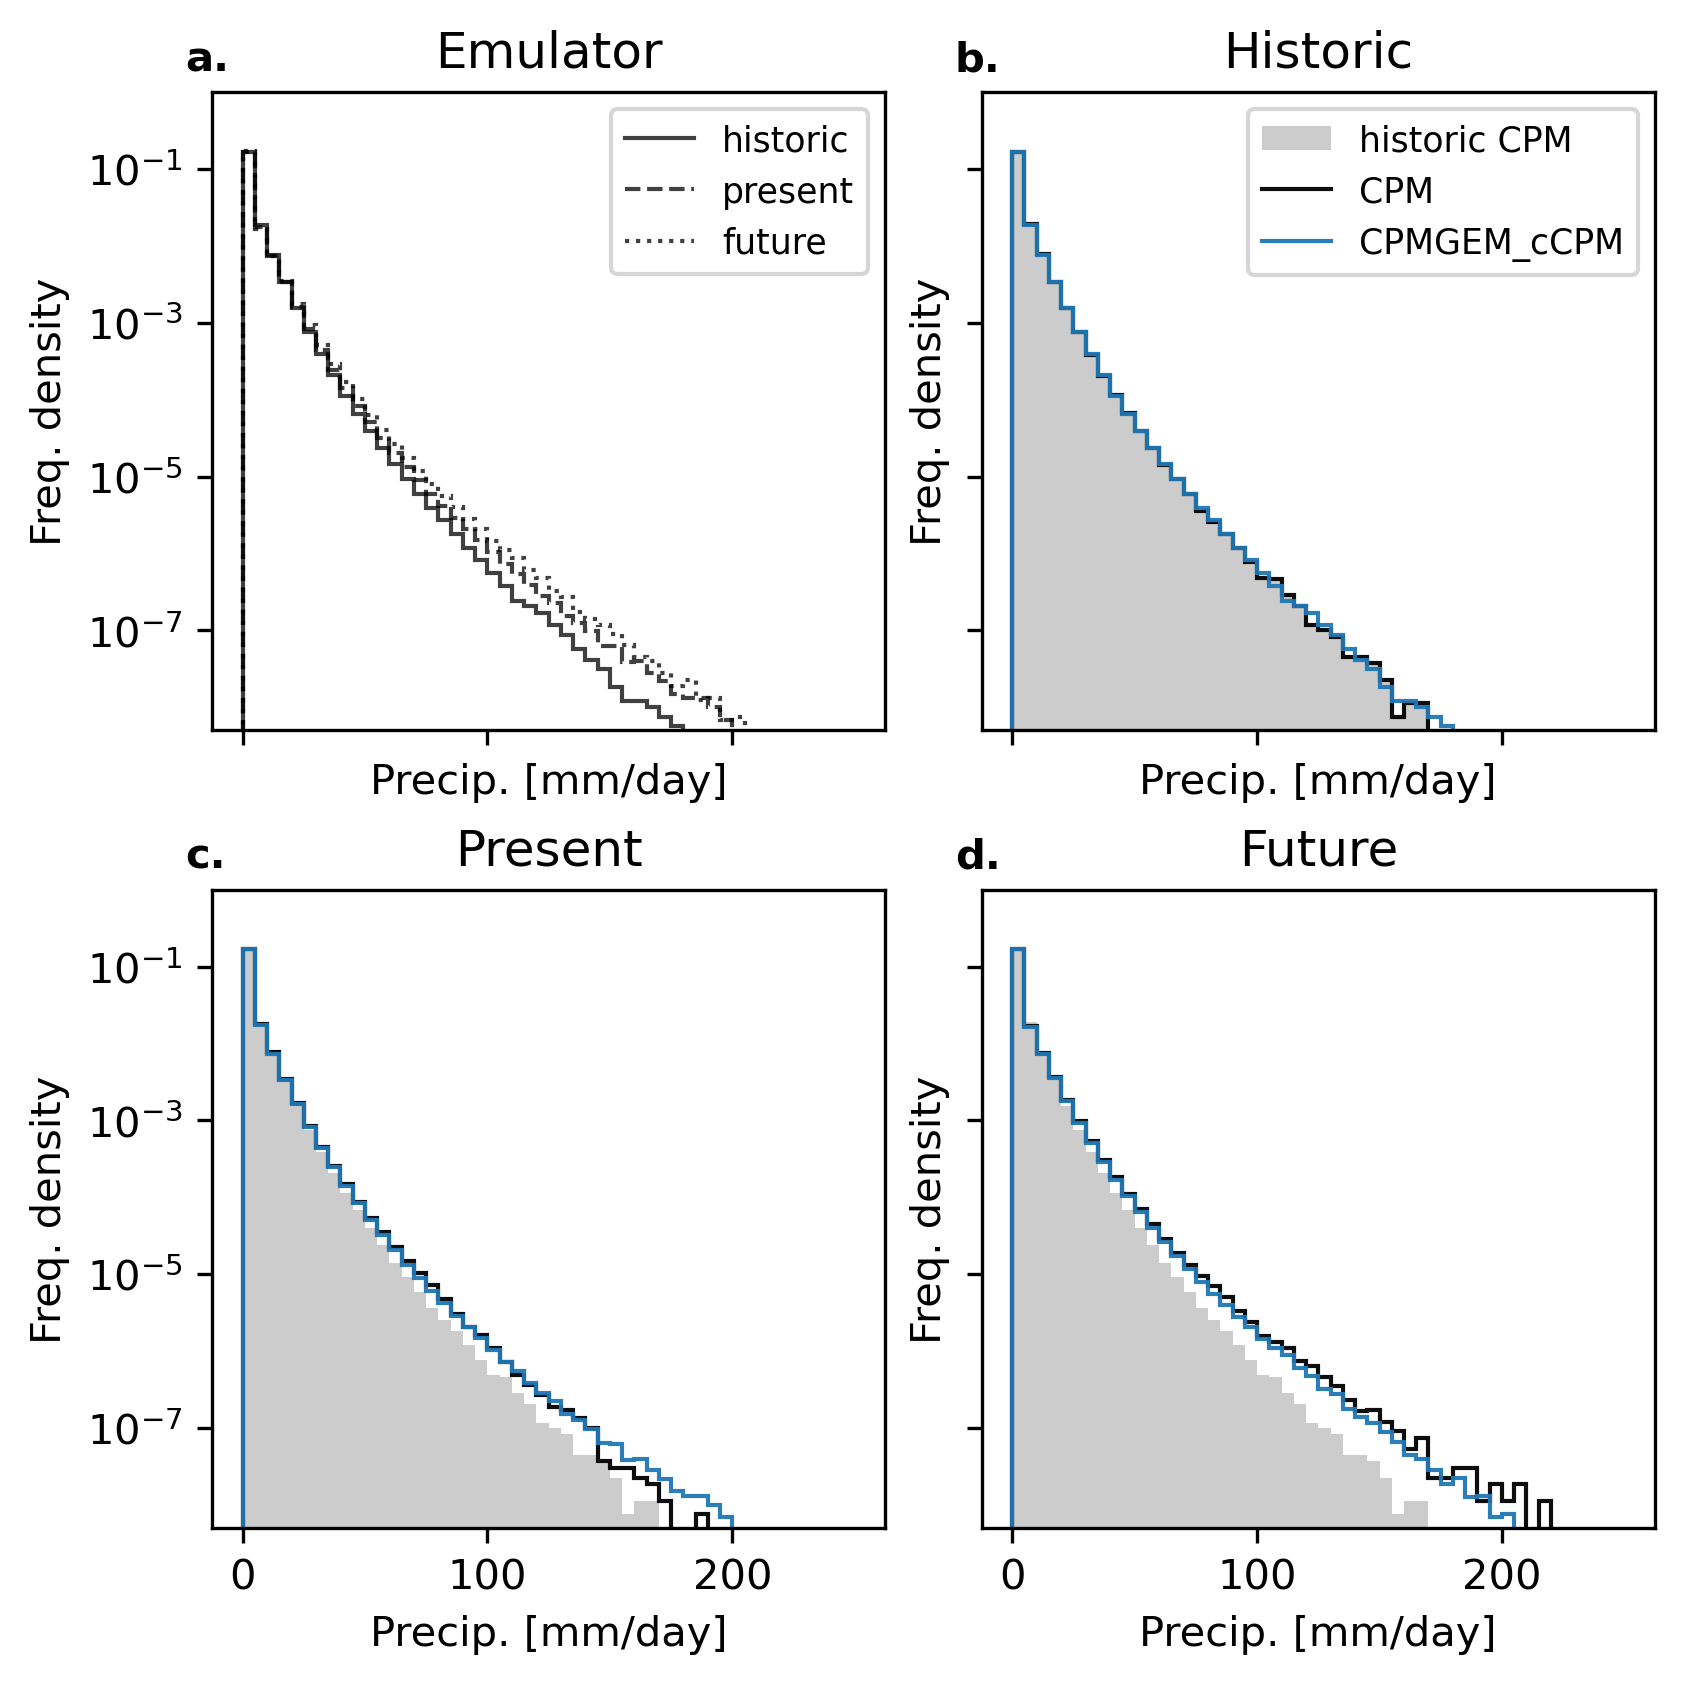

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"#### {var}", raw=True)
    for model, model_ds in CCS_DS.groupby("model"):
        IPython.display.display_markdown(f"##### {model}", raw=True)

        fd_fig = plt.figure(figsize=(5.5, 5.5), layout="compressed")
        pred_da = model_ds[f"pred_{var}"]

        if var == "pr":
            hrange = (0, 250)
        else:
            hrange = None
        plot_tp_fd(pred_da, CPM_DAS[var], fd_fig, MODELLABEL2SPEC[model]["source"], model, MODELLABEL2SPEC[model], hrange=hrange)

        plt.show()

## Figure: per Time Period distribution

* Frequency Density Histogram of rainfall intensities for each time period

#### pr

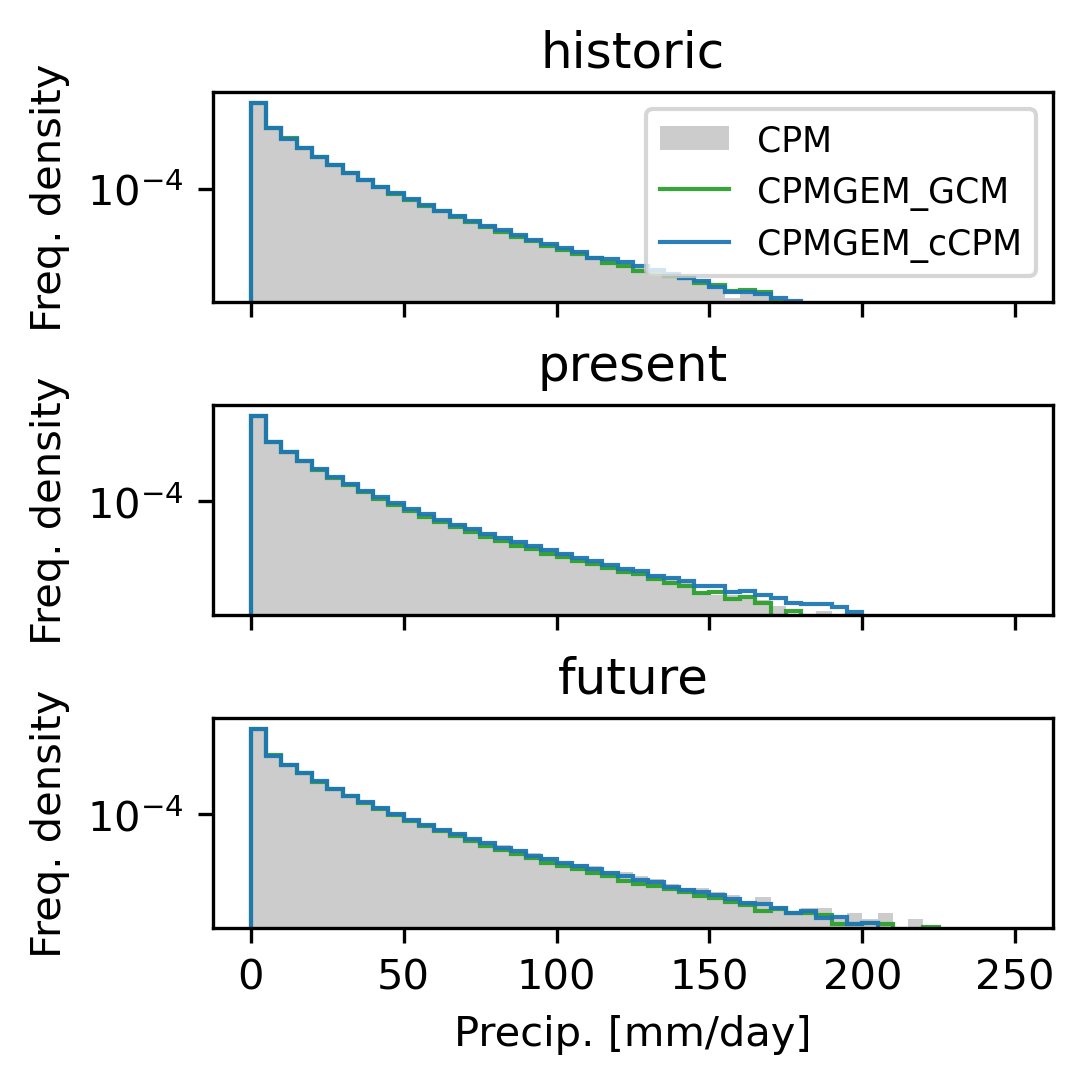

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"#### {var}", raw=True)
    
    fig = plt.figure(layout='constrained', figsize=(3.5, 3.5))
        
    # labels = [ label for mconfigs in MODELS.values() for label in mconfigs.keys() ]
    
    # meanb_axes_keys = list(map(lambda x: f"meanb {x}", labels))
    # meanb_spec = np.array(meanb_axes_keys).reshape(1,-1)
    
    # stddevb_axes_keys = list(map(lambda x: f"stddevb {x}", labels))
    # stddevb_spec = np.array(stddevb_axes_keys).reshape(1,-1)
    
    dist_spec = np.array(list(TIME_PERIODS.keys())).reshape(-1,1)
    
    spec = dist_spec
    
    axd = fig.subplot_mosaic(spec, sharex=True, sharey=True)#, gridspec_kw=dict(height_ratios=[3, 2, 2]), per_subplot_kw={ak: {"projection": cp_model_rotated_pole} for ak in meanb_axes_keys + stddevb_axes_keys})
    
    for tp_key, tp_ds in CCS_DS.groupby("time_period"):
        ax = axd[tp_key]
    
        hist_data = [ dict(data=model_ds[f"pred_{var}"], label=model, color=MODELLABEL2SPEC[model]["color"]) for model, model_ds in tp_ds.groupby("model") ]
        hrange=VAR_RANGES[var]
        plot_freq_density(hist_data, ax=ax, target_da=tp_ds[f"target_{var}"], legend=(tp_key=="historic"), linewidth=1, title=tp_key, hrange=hrange)

        ax.xaxis.label.set_visible(tp_key == "future")    

    plt.show()

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    metrics_ds = CCS_DS.groupby("time_period").map(lambda tp_ds: compute_metrics(tp_ds[f"pred_{var}"], tp_ds[f"target_{var}"], thresholds=DIST_THRESHOLDS[var]))
    pretty_table(metrics_ds, round=4, dim_order=["time_period", "model"])

### pr

RMS Mean Bias (mm/day) 
 RMS Std Dev Bias (mm/day) 
 Relative RMS Mean Bias (%) 
 Relative RMS Std Dev Bias (%) 
 J-S distance 
 Emu > 0.1 
 Emu > 0.1 - CPM > 0.1 
 Emu > 25 
 Emu > 25 - CPM > 25 
 Emu > 75 
 Emu > 75 - CPM > 75 
 Emu > 125 
 Emu > 125 - CPM > 125 
 
 
 time_period 
 model 
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 future 
 CPMGEM_GCM 
 0.1000 
 0.3200 
 3.5600 
 6.1500 
 0.0061 
 0.5104 
 0.0088 
 0.0102 
 -0.0014 
 0.0001 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.1000 
 0.2400 
 4.2000 
 4.6200 
 0.0040 
 0.4922 
 -0.0094 
 0.0109 
 -0.0007 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 historic 
 CPMGEM_GCM 
 0.1100 
 0.1600 
 3.4900 
 3.0500 
 0.0066 
 0.5827 
 0.0265 
 0.0080 
 -0.0001 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.0900 
 0.1500 
 2.6700 
 2.6800 
 0.0019 
 0.5584 
 0.0023 
 0.0082 
 0.0001 
 0.0001 
 0.0000 
 0.0000 
 0.0000 
 
 
 present 
 CPMGEM_GCM 
 0.1000 
 0.2900 
 3.5200 
 5.8000 
 0.0066 
 0.5465 
 0.0142 
 0.0087 
 -0.0011 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.1000 
 0.2300 
 4.1400 
 4.4200 
 0.0044 
 0.5264 
 -0.0059 
 0.0094 
 -0.0004 
 0.0001 
 -0.0000 
 0.0000 
 0.0000

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)
    
    quantiles_da = xr.concat([
        chained_groupby_map(
            CCS_DS[f"pred_{var}"], 
            ["model", "time_period"], 
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time", "sample_id"])
        ),
        chained_groupby_map(
            CCS_DS[f"target_{var}"], 
            ["time_period"], 
            lambda gda: gda.quantile(q=PER_GRIDBOX_QUANTILES, dim=["ensemble_member", "time"])
        ).expand_dims(model=["CPM"])],
        dim="model",
    )
    
    quantiles_change_da = (100*(quantiles_da.sel(time_period="future") - quantiles_da.sel(time_period="historic")) / quantiles_da.sel(time_period="historic")).drop("time_period").rename("Relative change in quantile [%]")
    
    
    pretty_table(
        quantiles_change_da.mean(["grid_latitude", "grid_longitude"]), 
        round=1, 
        caption="Domain mean of annual quantile changes",
        dim_order=["quantile", "model"],
    )

### pr

Domain mean of annual quantile changes 
 
 
   
   
 Relative change in quantile [%] 
 
 
 quantile 
 model 
   
 
 
 
 
 0.990000 
 CPMGEM_cCPM 
 9.7 
 
 
 CPMGEM_GCM 
 7.4 
 
 
 CPM 
 12.5 
 
 
 0.999000 
 CPMGEM_cCPM 
 13.8 
 
 
 CPMGEM_GCM 
 9.7 
 
 
 CPM 
 17.0

## Figure: Fractional contribution

* Fractional contribution of rainfall intensities for each time period
* Change in fractional contribution of rainfall intensities from historic to future

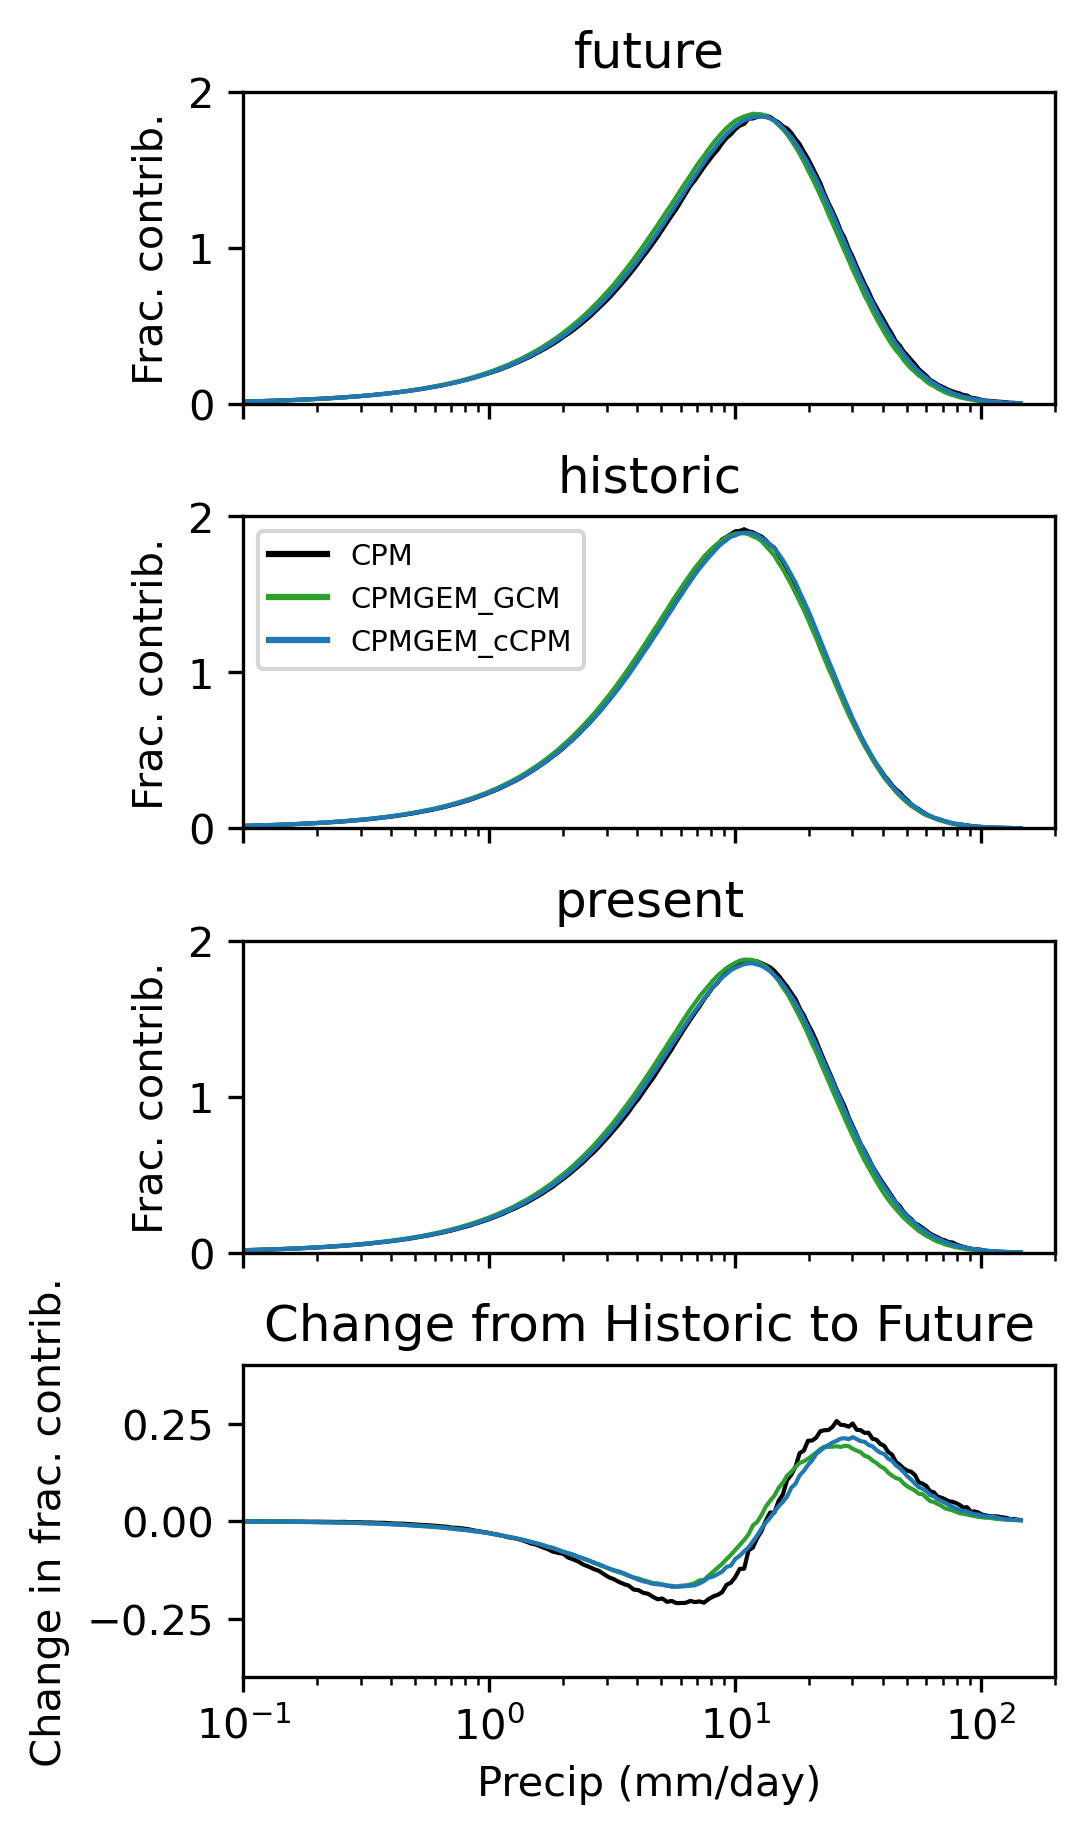

In [ ]:
for var in eval_vars:
    if var not in ["pr"]:
        continue
    
    fcdata = ccs_fc_da(CCS_DS[f"pred_{var}"], CCS_DS[f"target_{var}"])
    fig = plt.figure(layout='constrained', figsize=(3.5, 6))
    plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()})
    plt.show()

### Bootstrapped fractional contributions

In [ ]:
import gc

bs_cpm_das = { var: chained_groupby_map(CCS_DS[f"target_{var}"], ["time_period", "time.season"], resample_examples, niterations=niterations) for var in eval_vars if var in ["pr"] }

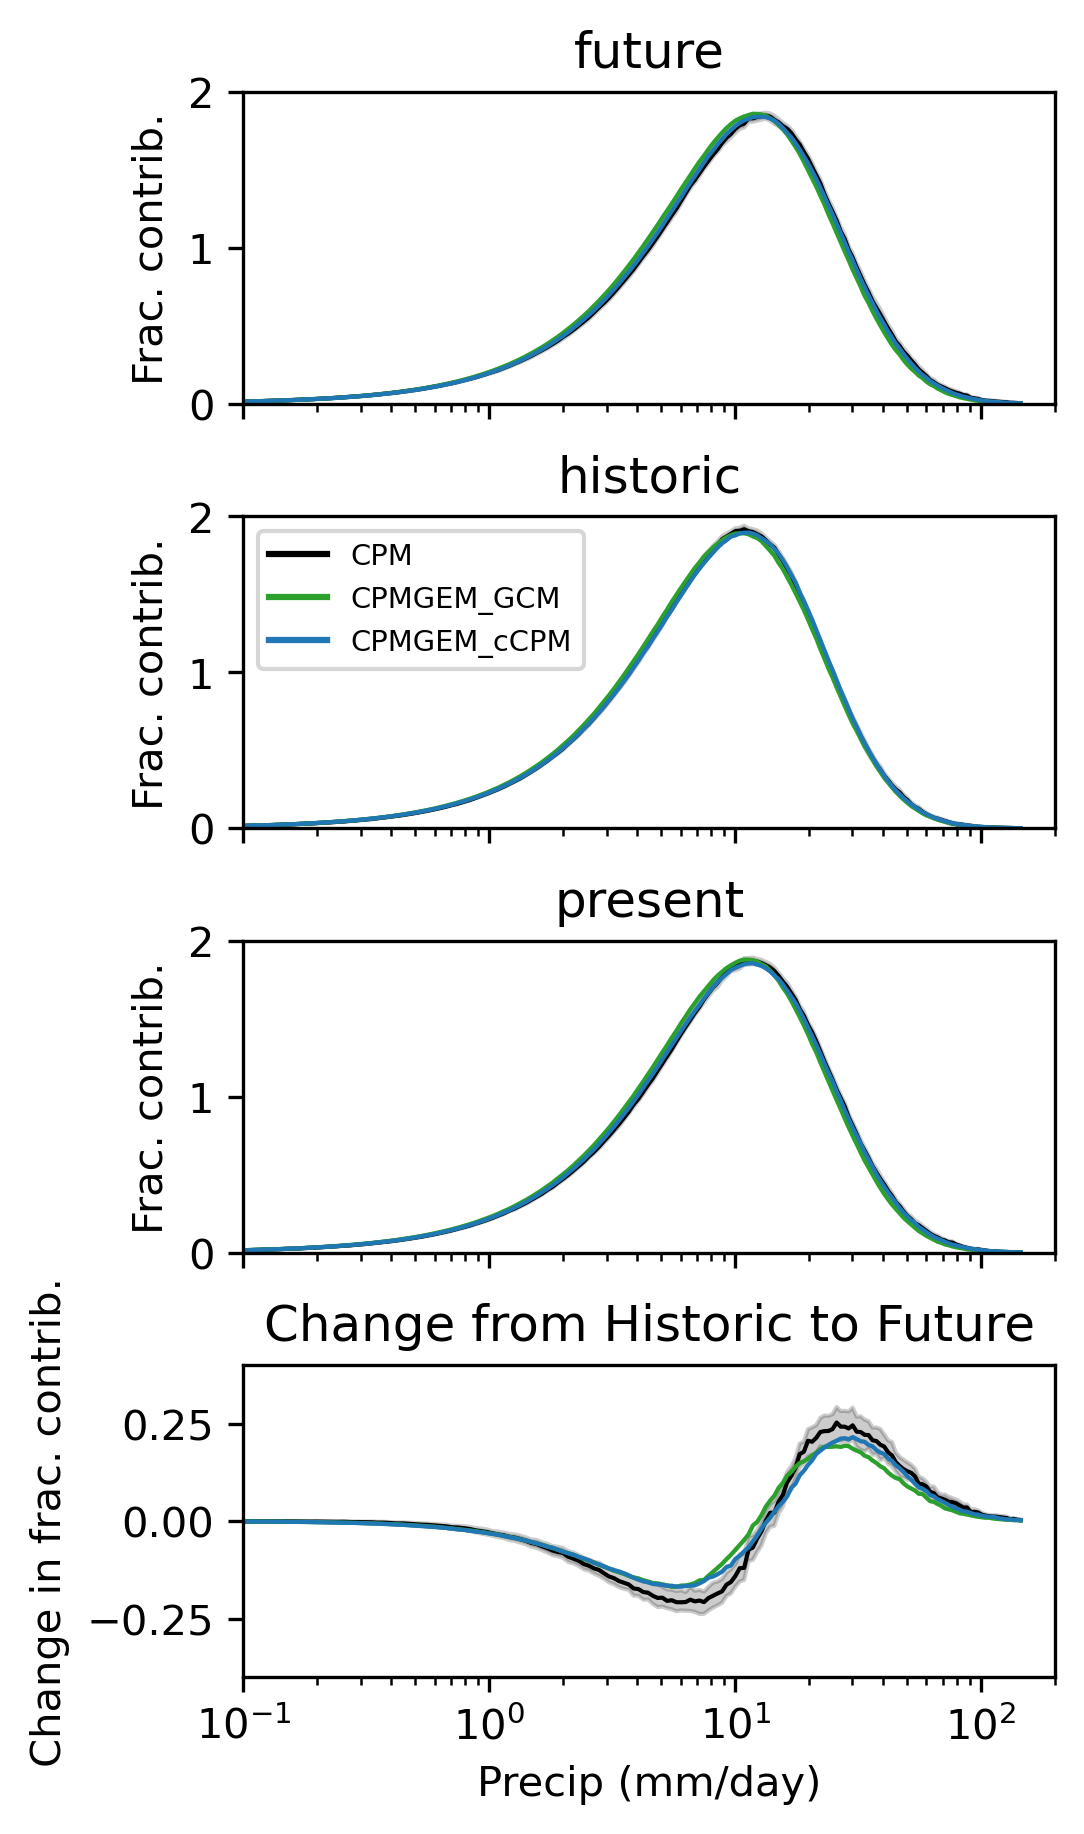

In [ ]:
for var, bs_cpm_da in bs_cpm_das.items():
    
    fcdata = ccs_fc_da(CCS_DS[f"pred_{var}"], bs_cpm_da, extra_cpm_dims=["iteration"])
    
    fig = plt.figure(layout='constrained', figsize=(3.5, 6))
    plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
    plt.show()

#### CPMGEM_GCM

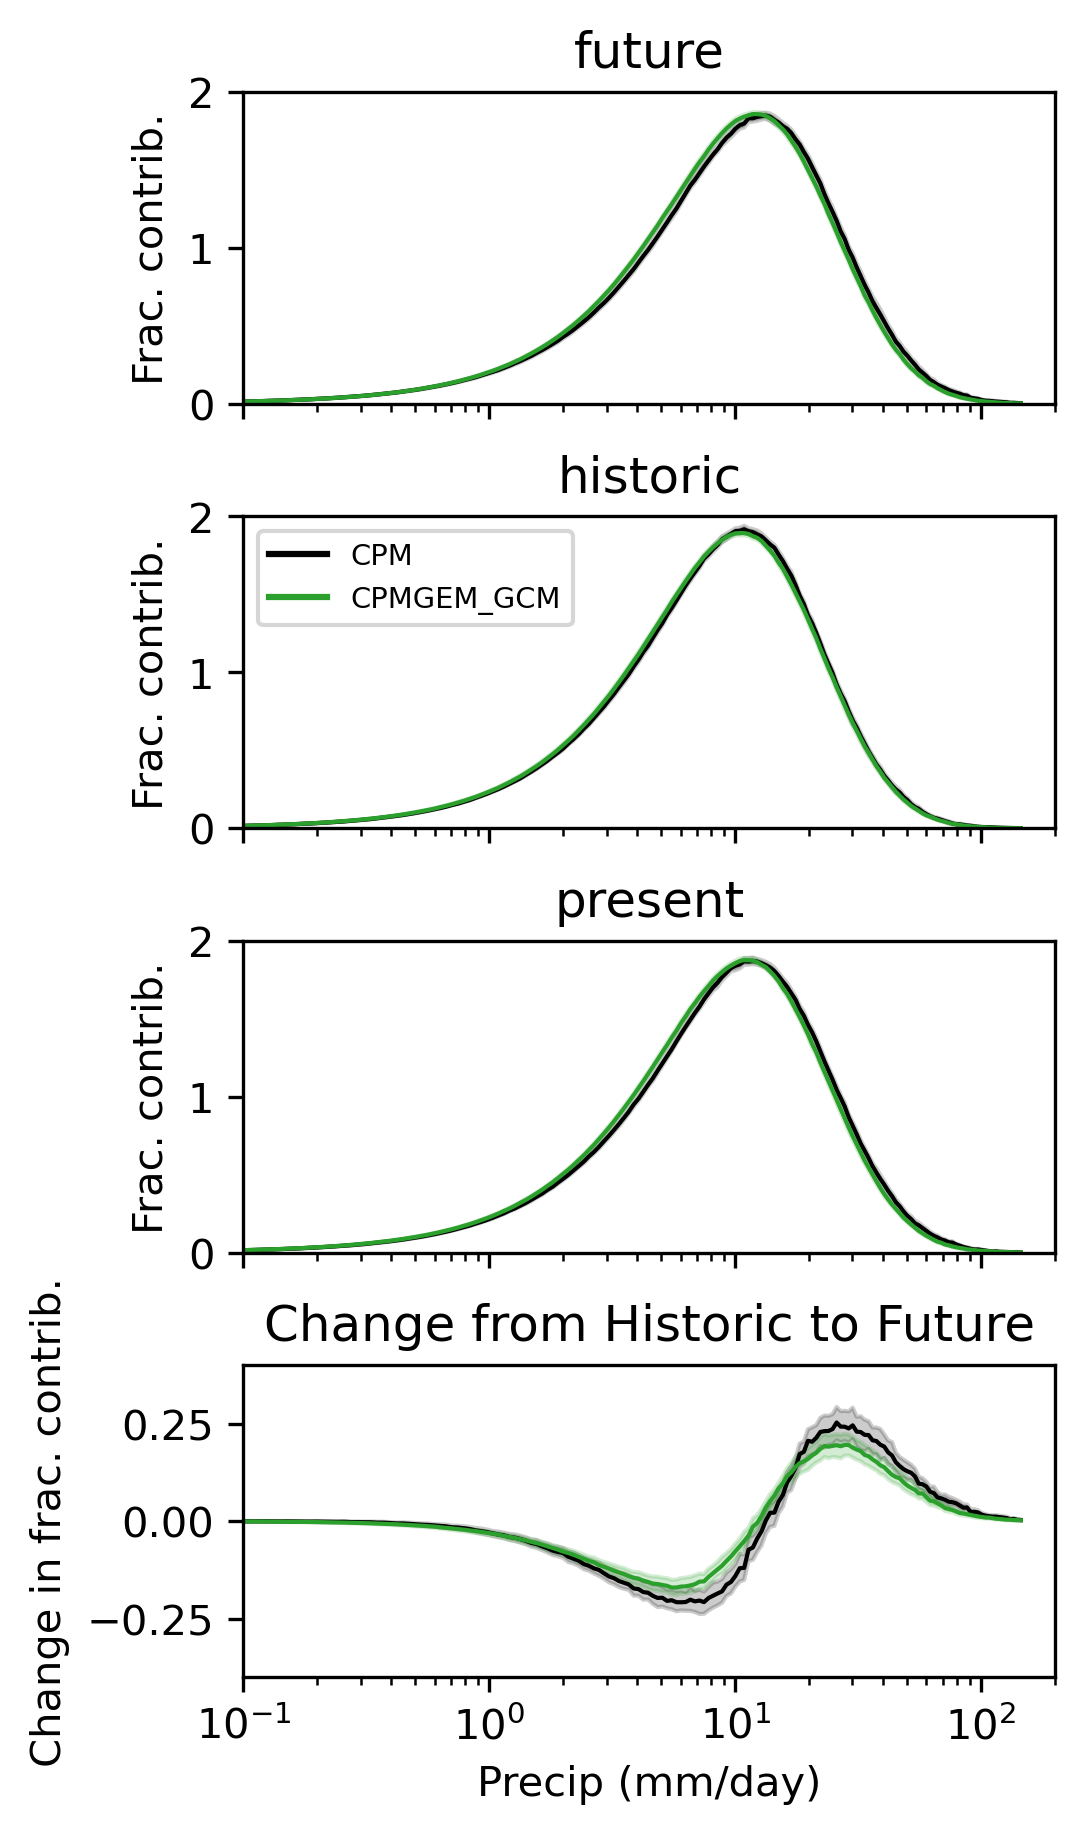

#### CPMGEM_cCPM

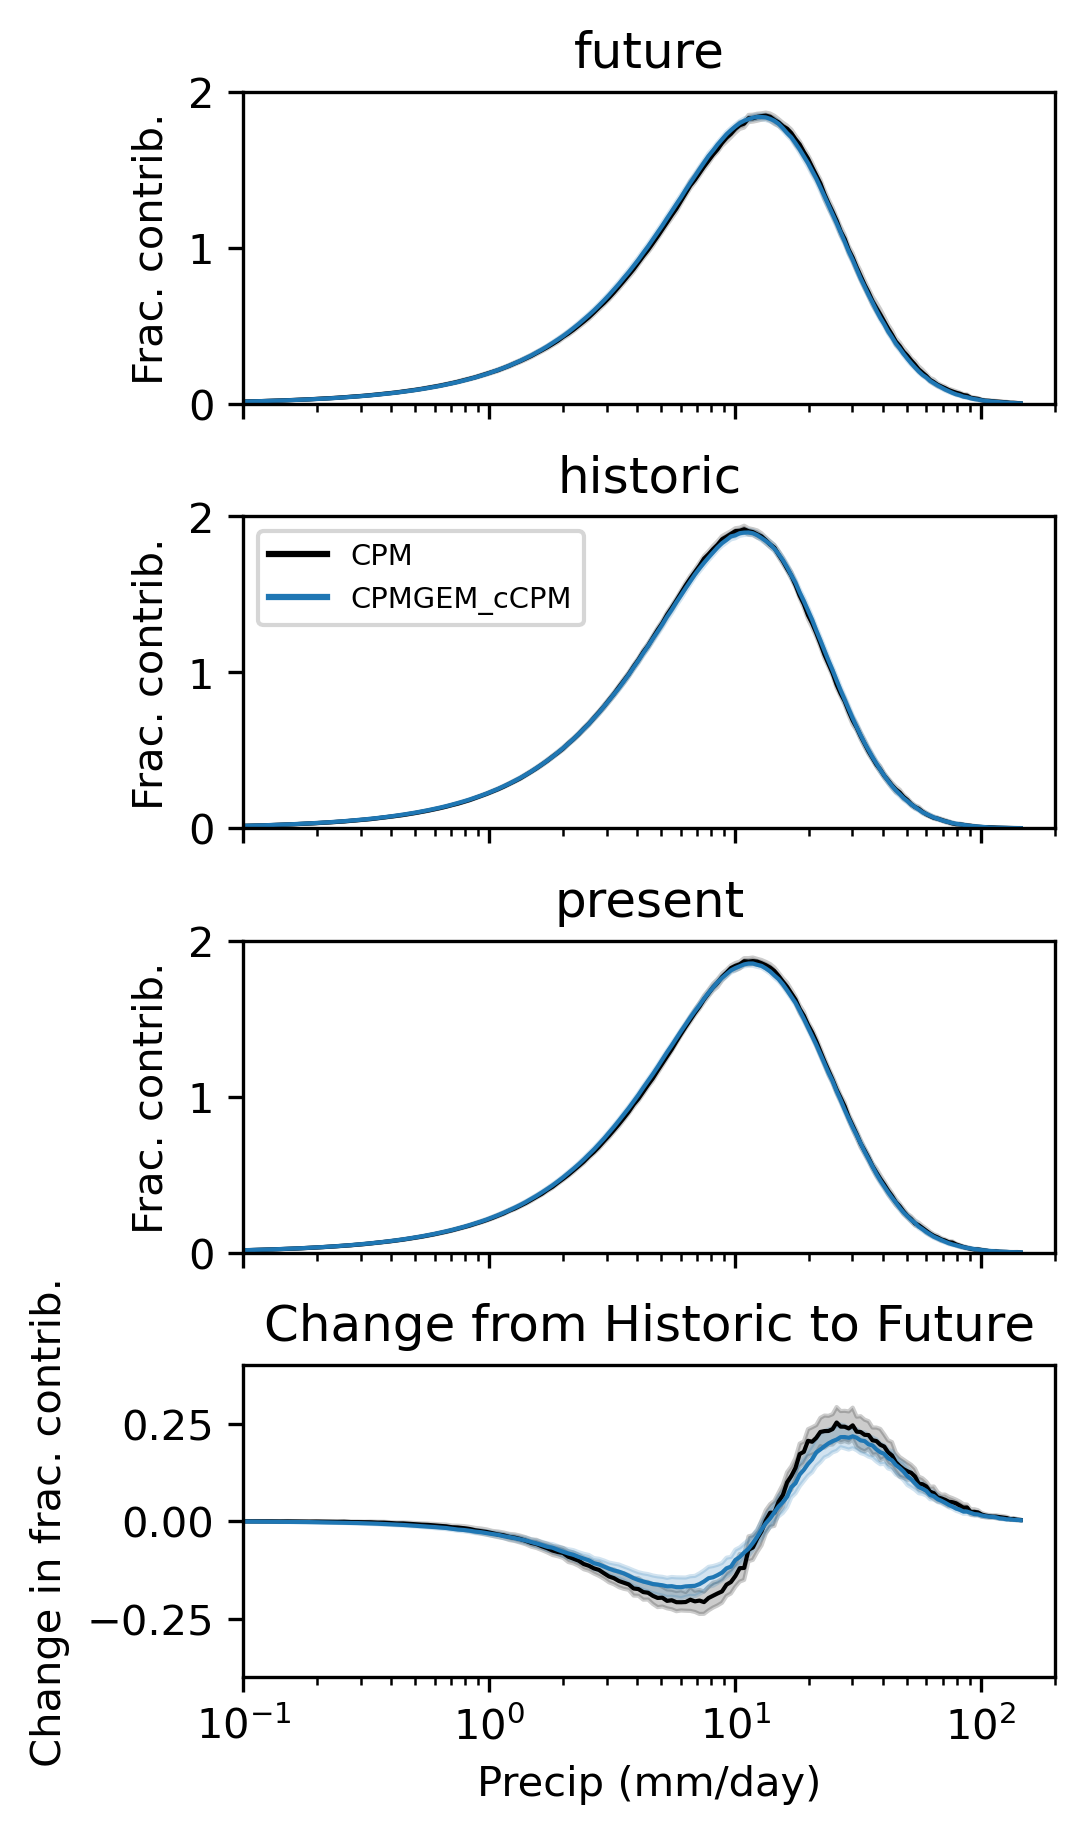

In [ ]:
for var, bs_cpm_da in bs_cpm_das.items():

    for model, model_pred_da in CCS_DS[f"pred_{var}"].groupby("model", squeeze=False):

        IPython.display.display_markdown(f"#### {model}", raw=True)    

        bs_pred_da = chained_groupby_map(model_pred_da.squeeze("model"), ["time_period", "time.season"], resample_examples, niterations=niterations)

        fcdata = ccs_fc_da(bs_pred_da.expand_dims(model=[model]), bs_cpm_da, extra_pred_dims=["iteration"], extra_cpm_dims=["iteration"])
        
        fig = plt.figure(layout='constrained', figsize=(3.5, 6))
        plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
        plt.show()
    
        del bs_pred_da

In [ ]:
del bs_cpm_das

#### CPMGEM_GCM

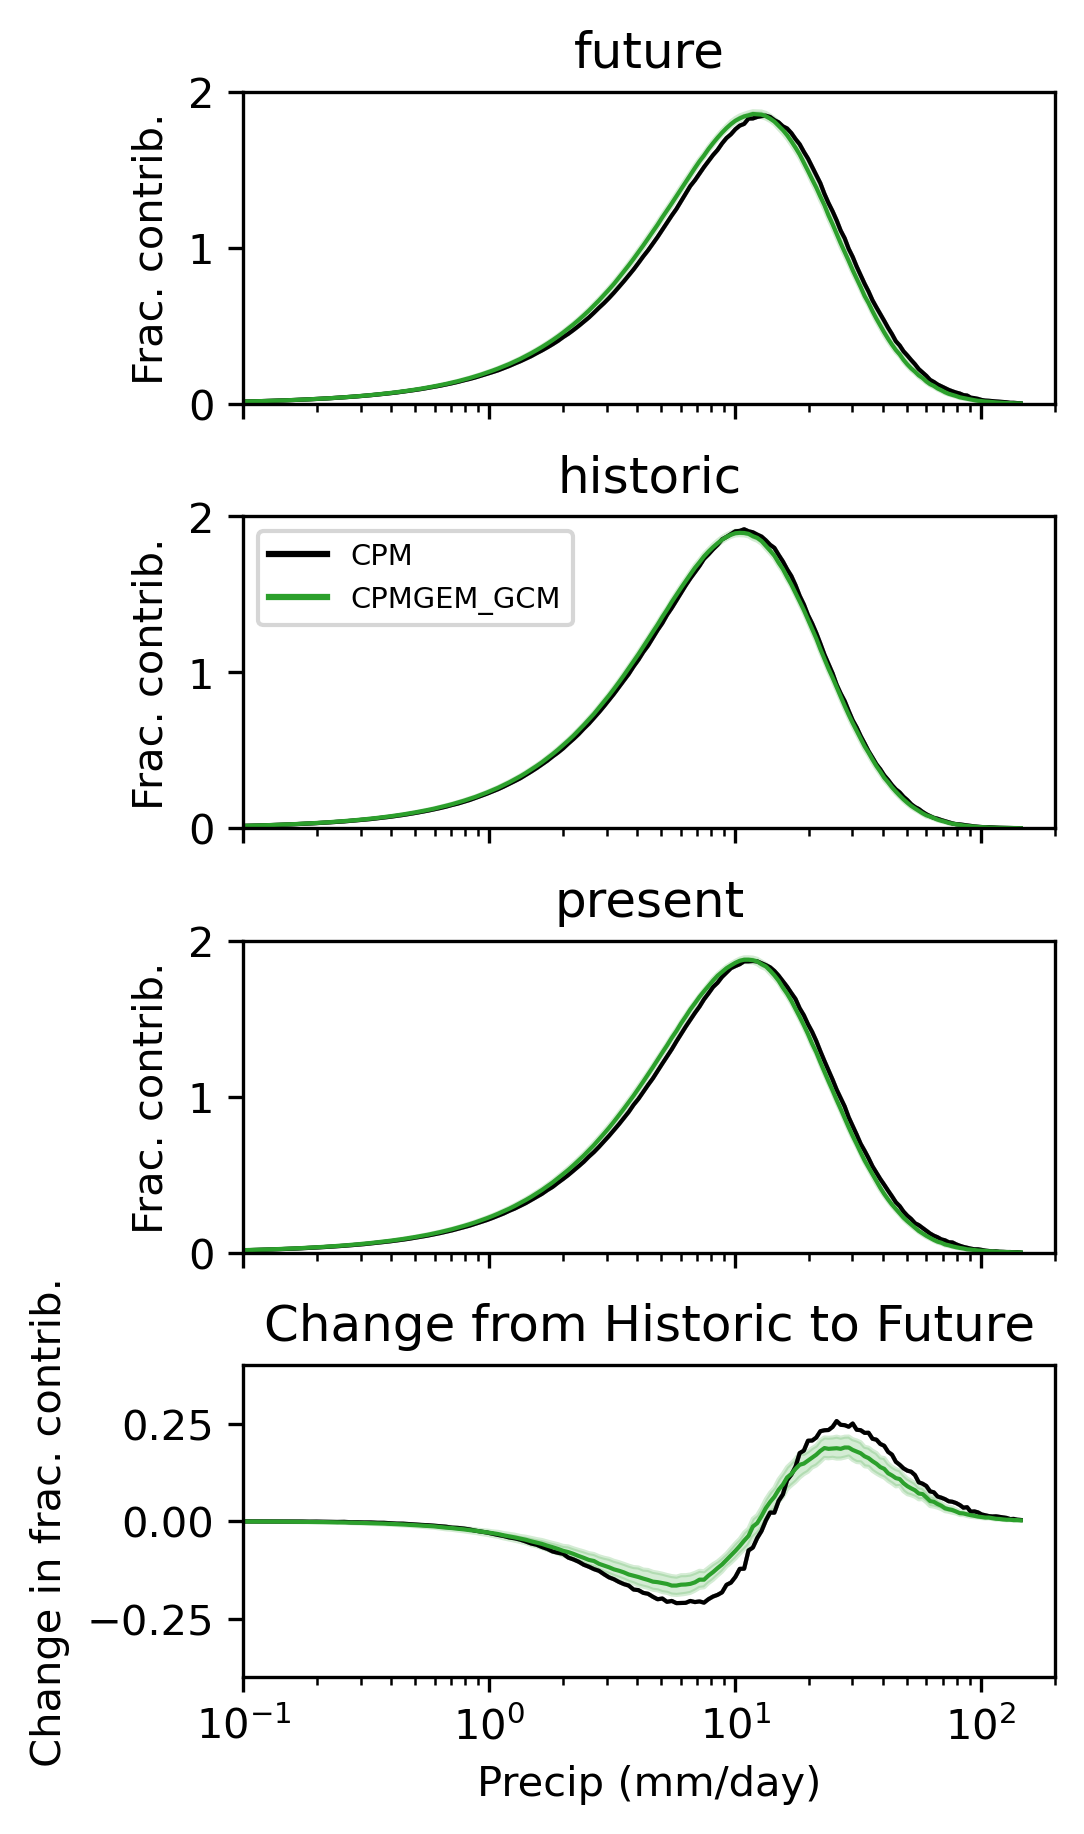

#### CPMGEM_cCPM

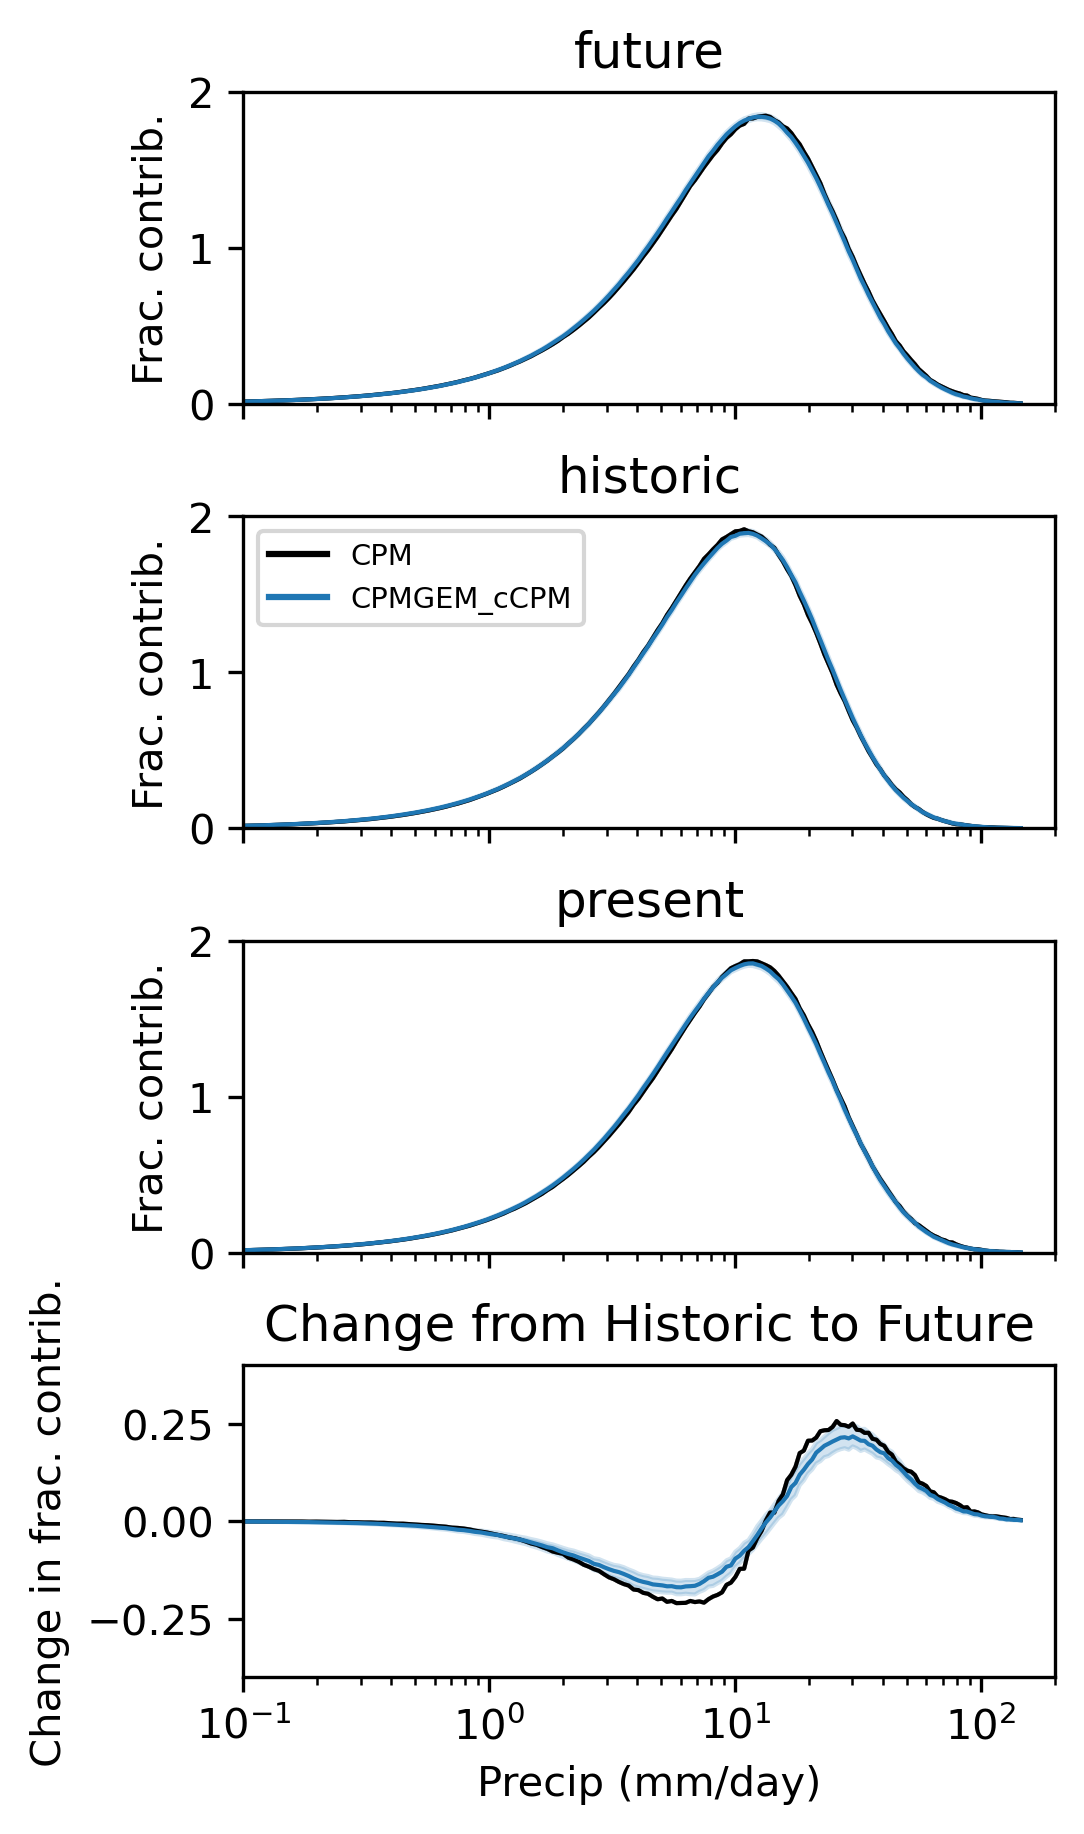

In [ ]:
for var in eval_vars:
    if var not in ["pr"]:
        continue

    for model, model_pred_da in CCS_DS[f"pred_{var}"].groupby("model", squeeze=False):

        IPython.display.display_markdown(f"#### {model}", raw=True)    

        bs_pred_da = chained_groupby_map(model_pred_da.squeeze("model"), ["time_period", "time.season"], resample_examples, niterations=niterations)

        fcdata = ccs_fc_da(bs_pred_da.expand_dims(model=[model]), CCS_DS[f"target_{var}"], extra_pred_dims=["iteration"])
        
        fig = plt.figure(layout='constrained', figsize=(3.5, 6))
        plot_ccs_fc_figure(fig, fcdata, palette={label: spec["color"] for label, spec in MODELLABEL2SPEC.items()}, errorbar=("pi", 90))
        plt.show()
    
        del bs_pred_da